In [ ]:
import pandas as pd
df = pd.read_csv("/kaggle/input/threatnews/CyberAttack News Tweets/df_m.csv")

In [ ]:
df

,text,anottator1,anottator2,anottator3,majority
0,@Cloudflare reports #ransom #DDoS attacks have...,Not_News,Not_News,Not_News,Not_News
1,Here’s the one thing you mustn’t tell hackers ...,Not_News,Not_News,Not_News,Not_News
2,@TactiKoolSec There was the time where a not-s...,Not_News,Not_News,Not_News,Not_News
3,Ransomware is a fast-growing threat impacting ...,Not_News,Not_News,Not_News,Not_News
4,Five key cloud and innovation takeaways from I...,Not_News,Not_News,Not_News,Not_News
...,...,...,...,...,...
36075,The UK’s National Cyber Security Centre has be...,Normal_News,Normal_News,Normal_News,Normal_News
36076,Free Crypto Coins Tips : LG and Mitsubishi Hit...,Normal_News,Normal_News,Not_News,Normal_News
36077,Conti ransomware deployed in IcedID banking Tr...,Normal_News,Normal_News,Not_News,Normal_News
36078,RT @MiddleEastMnt: Poland admits using Israel’...,Normal_News,Normal_News,Normal_News,Normal_News


In [ ]:
df = df.drop(["anottator1", "anottator2", "anottator3"], axis=1)

In [ ]:
df

,text,majority
0,@Cloudflare reports #ransom #DDoS attacks have...,Not_News
1,Here’s the one thing you mustn’t tell hackers ...,Not_News
2,@TactiKoolSec There was the time where a not-s...,Not_News
3,Ransomware is a fast-growing threat impacting ...,Not_News
4,Five key cloud and innovation takeaways from I...,Not_News
...,...,...
36075,The UK’s National Cyber Security Centre has be...,Normal_News
36076,Free Crypto Coins Tips : LG and Mitsubishi Hit...,Normal_News
36077,Conti ransomware deployed in IcedID banking Tr...,Normal_News
36078,RT @MiddleEastMnt: Poland admits using Israel’...,Normal_News


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into features (X) and labels (y)
X = df['text']
y = df['majority']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust the max_features parameter
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import torch
from scipy.sparse import coo_matrix
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.preprocessing import LabelEncoder

# Encode the labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Create a document-word graph for the training data
rows_train, cols_train = X_train_vec.nonzero()
edges_train = np.vstack((rows_train, cols_train + len(X_train))).T
values_train = X_train_vec.data

# Create adjacency matrix in COO format
adj_train = coo_matrix((values_train, (rows_train, cols_train + len(X_train))),
                       shape=(len(X_train) + len(vectorizer.vocabulary_), len(X_train) + len(vectorizer.vocabulary_)))

# Create PyTorch Geometric Data object for training
data_train = Data()
data_train.x = torch.tensor(np.vstack([X_train_vec.toarray(), np.zeros((len(vectorizer.vocabulary_), X_train_vec.shape[1]))]), dtype=torch.float)
data_train.edge_index, data_train.edge_attr = from_scipy_sparse_matrix(adj_train)
data_train.y = torch.tensor(y_train_enc, dtype=torch.long)

# Mask for training data (only document nodes)
train_mask = torch.zeros(len(X_train), dtype=torch.bool)
train_mask[:len(X_train)] = True
data_train.train_mask = train_mask

# Create a document-word graph for the testing data
rows_test, cols_test = X_test_vec.nonzero()
edges_test = np.vstack((rows_test, cols_test + len(X_test))).T
values_test = X_test_vec.data

# Create adjacency matrix in COO format
adj_test = coo_matrix((values_test, (rows_test, cols_test + len(X_test))),
                      shape=(len(X_test) + len(vectorizer.vocabulary_), len(X_test) + len(vectorizer.vocabulary_)))

# Create PyTorch Geometric Data object for testing
data_test = Data()
data_test.x = torch.tensor(np.vstack([X_test_vec.toarray(), np.zeros((len(vectorizer.vocabulary_), X_test_vec.shape[1]))]), dtype=torch.float)
data_test.edge_index, data_test.edge_attr = from_scipy_sparse_matrix(adj_test)
data_test.y = torch.tensor(y_test_enc, dtype=torch.long)

# Mask for testing data (only document nodes)
test_mask = torch.zeros(len(X_test), dtype=torch.bool)
test_mask[:len(X_test)] = True
data_test.test_mask = test_mask


Gnn

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate the model
model = GCN(num_node_features=data_train.x.shape[1], num_classes=len(label_encoder.classes_))


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Lists to store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Function to calculate accuracy
def calculate_accuracy(pred, true):
    return accuracy_score(true, pred)

# Function to calculate metrics
def calculate_metrics(pred, true):
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred, average='weighted')
    recall = recall_score(true, pred, average='weighted')
    f1 = f1_score(true, pred, average='weighted')
    return accuracy, precision, recall, f1

# Training loop with metrics calculation
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    # Train the model
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    # Use only the document nodes for training
    loss = loss_fn(out[:len(X_train)][data_train.train_mask], data_train.y)
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    with torch.no_grad():
        pred_train = out[:len(X_train)].max(dim=1)[1]
        train_acc = calculate_accuracy(pred_train.cpu().numpy(), data_train.y.cpu().numpy())

    # Validate the model
    model.eval()
    with torch.no_grad():
        out = model(data_test)
        # Use only the document nodes for testing
        val_loss = loss_fn(out[:len(X_test)], data_test.y)
        pred_test = out[:len(X_test)].max(dim=1)[1]
        val_acc = calculate_accuracy(pred_test.cpu().numpy(), data_test.y.cpu().numpy())

    # Append metrics to lists
    train_losses.append(loss.item())
    train_accs.append(train_acc)
    val_losses.append(val_loss.item())
    val_accs.append(val_acc)

    if epoch % 1 == 0:
        print(f'Epoch {epoch}/{num_epochs}')
        print(f'Train - Loss: {loss.item():.4f}, Accuracy: {train_acc:.4f}, Val - Loss: {val_loss.item():.4f}, Accuracy: {val_acc:.4f}')
#         print(f'Val - Loss: {val_loss.item():.4f}, Accuracy: {val_acc:.4f}')



Epoch 1/5
Train - Loss: 0.0714, Accuracy: 0.9764, Val - Loss: 0.1180, Accuracy: 0.9676
Epoch 2/5
Train - Loss: 0.0707, Accuracy: 0.9762, Val - Loss: 0.1181, Accuracy: 0.9673
Epoch 3/5
Train - Loss: 0.0685, Accuracy: 0.9768, Val - Loss: 0.1176, Accuracy: 0.9676
Epoch 4/5
Train - Loss: 0.0655, Accuracy: 0.9769, Val - Loss: 0.1179, Accuracy: 0.9673
Epoch 5/5
Train - Loss: 0.0649, Accuracy: 0.9777, Val - Loss: 0.1188, Accuracy: 0.9674


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test():
    model.eval()
    with torch.no_grad():
        out = model(data_test)
        # Use only the document nodes for testing
        _, pred = out[:len(X_test)].max(dim=1)

        # Calculate metrics
        true = data_test.y.cpu().numpy()
        pred = pred.cpu().numpy()

        acc = accuracy_score(true, pred)
        precision = precision_score(true, pred, average='weighted')
        recall = recall_score(true, pred, average='weighted')
        f1 = f1_score(true, pred, average='weighted')

    return acc, precision, recall, f1

# Testing the model
test_acc, test_precision, test_recall, test_f1 = test()

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-score: {test_f1:.4f}')


Test Accuracy: 0.9674
Test Precision: 0.9663
Test Recall: 0.9674
Test F1-score: 0.9663


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


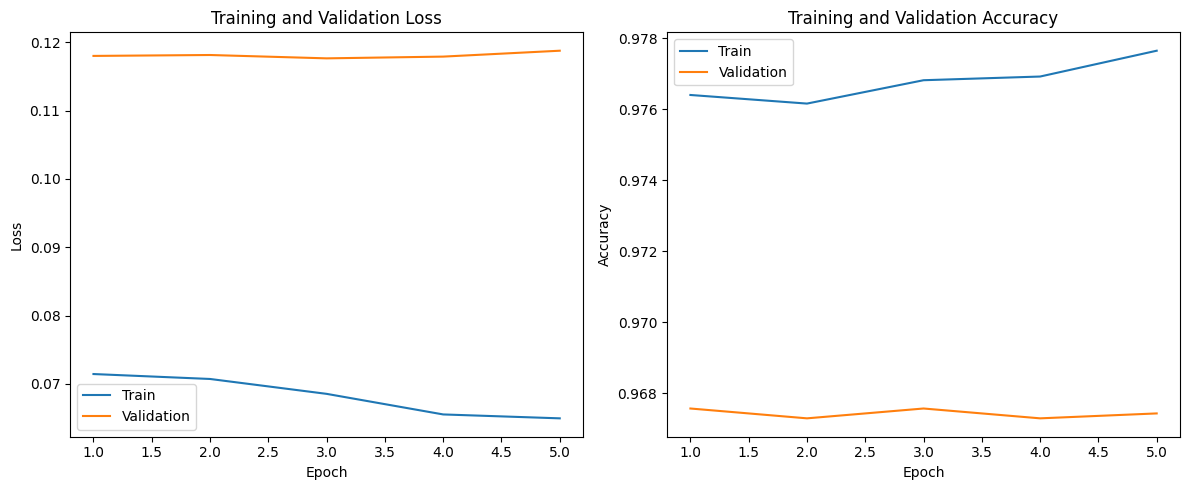

In [ ]:
# Plotting the training and validation metrics
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


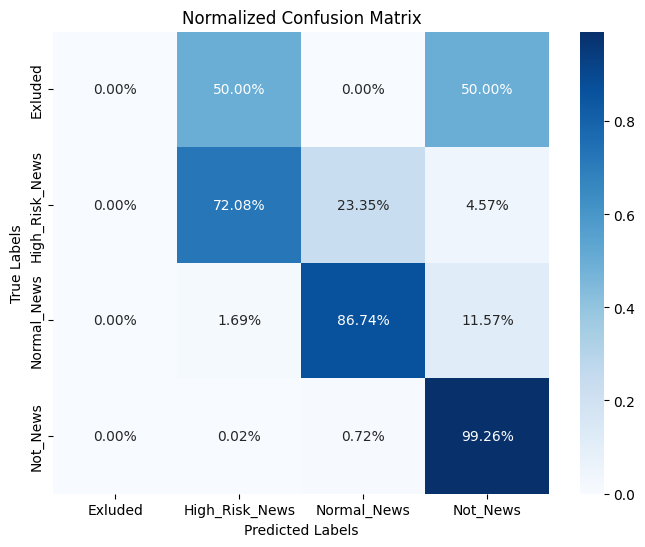


Classification Report:
                precision    recall  f1-score   support

       Exluded       0.00      0.00      0.00         2
High_Risk_News       0.90      0.72      0.80       197
   Normal_News       0.88      0.87      0.87       769
      Not_News       0.98      0.99      0.99      6248

      accuracy                           0.97      7216
     macro avg       0.69      0.65      0.67      7216
  weighted avg       0.97      0.97      0.97      7216



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot confusion matrix with percentages
def plot_confusion_matrix(cm, classes, normalize=False, cmap='Blues'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap=cmap,
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot normalized confusion matrix
plot_confusion_matrix(cm, label_encoder.classes_, normalize=True)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))


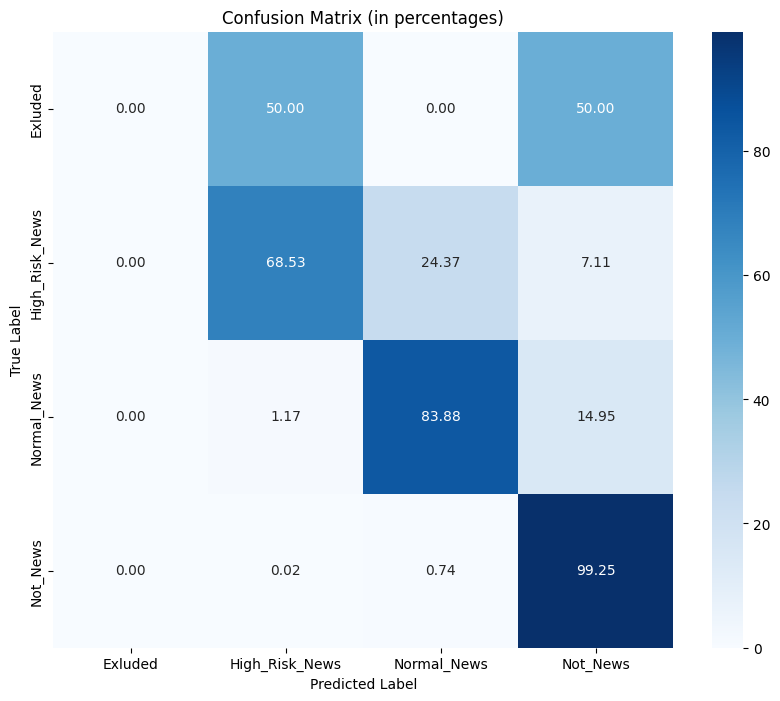


Classification Report:
                precision    recall  f1-score   support

       Exluded       0.00      0.00      0.00         2
High_Risk_News       0.92      0.69      0.79       197
   Normal_News       0.87      0.84      0.86       769
      Not_News       0.98      0.99      0.99      6248

      accuracy                           0.97      7216
     macro avg       0.69      0.63      0.66      7216
  weighted avg       0.97      0.97      0.97      7216



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Get predictions for the test set
with torch.no_grad():
    out = model(data_test)
    _, y_pred = out[:len(X_test)].max(dim=1)
    y_pred = y_pred.cpu().numpy()
    y_true = data_test.y.cpu().numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (in percentages)')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


/tmp/ipykernel_33/28380481.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')


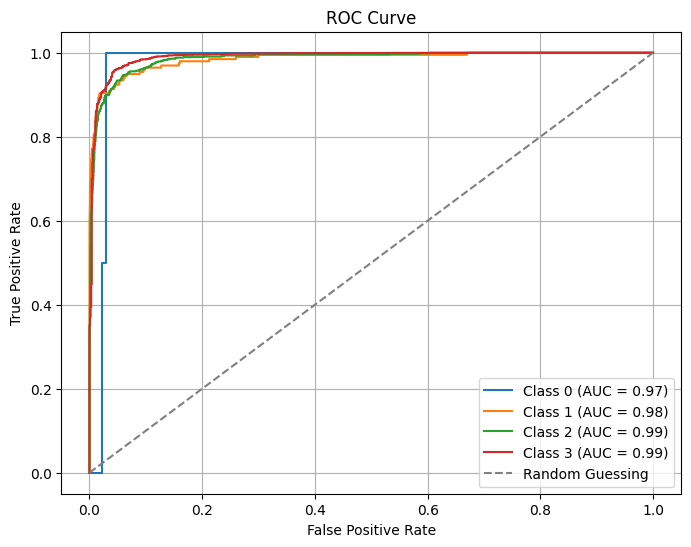

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Get predicted probabilities for the test set
with torch.no_grad():
    out = model(data_test)
    y_scores = torch.nn.functional.softmax(out[:len(X_test)], dim=1).cpu().numpy()

# Binarize the labels for the ROC curve
y_true = data_test.y.cpu().numpy()
n_classes = len(np.unique(y_true))
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


deepgraphnet

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:

# Define the model (ensure this uses the correct TensorFlow/Keras implementation)
class GCN(tf.keras.Model):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation=None)
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.dropout1 = tf.keras.layers.Dropout(0.5)

        self.dense2 = tf.keras.layers.Dense(32, activation=None)
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.dropout2 = tf.keras.layers.Dropout(0.5)

        self.dense3 = tf.keras.layers.Dense(16, activation=None)
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.ReLU()
        self.dropout3 = tf.keras.layers.Dropout(0.5)

        self.dense4 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.dense2(inputs)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.dense3(inputs)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.dense4(inputs)
        return x



In [ ]:
# Instantiate the model
num_node_features = X_train_vec.shape[1]
num_classes = len(label_encoder.classes_)
model = GCN(num_node_features=num_node_features, num_classes=num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



In [ ]:
# Training loop with metrics calculation
num_epochs = 5
batch_size = 32

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    # Train the model
    history = model.fit(X_train_vec.toarray(), y_train_encoded, batch_size=batch_size, epochs=1, verbose=0)

    # Calculate training accuracy and loss
    train_loss = history.history['loss'][0]
    train_acc = history.history['accuracy'][0]


    # Validate the model
    val_loss, val_acc = model.evaluate(X_test_vec.toarray(), y_test_encoded, verbose=0)

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if epoch % 1 == 0:
        print(f'Epoch {epoch}/{num_epochs}')
        print(f'Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
        #print(f'Val - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')



/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1/5
Train - Loss: 0.2301, Accuracy: 0.9350, Val - Loss: 0.1211, Accuracy: 0.9640
Epoch 2/5
Train - Loss: 0.0886, Accuracy: 0.9730, Val - Loss: 0.0965, Accuracy: 0.9698
Epoch 3/5
Train - Loss: 0.0633, Accuracy: 0.9796, Val - Loss: 0.0895, Accuracy: 0.9720
Epoch 4/5
Train - Loss: 0.0496, Accuracy: 0.9850, Val - Loss: 0.0872, Accuracy: 0.9719
Epoch 5/5
Train - Loss: 0.0405, Accuracy: 0.9877, Val - Loss: 0.0869, Accuracy: 0.9713


In [ ]:
# Predictions for validation set
y_test_pred = model.predict(X_test_vec.toarray()).argmax(axis=1)
y_test_true = y_test_encoded

# Calculate metrics for the validation set
val_accuracy = accuracy_score(y_test_true, y_test_pred)
val_precision = precision_score(y_test_true, y_test_pred, average='weighted')
val_recall = recall_score(y_test_true, y_test_pred, average='weighted')
val_f1 = f1_score(y_test_true, y_test_pred, average='weighted')

# Print metrics
print('Validation Metrics:')
print(f'Accuracy: {val_accuracy:.4f}')
print(f'Precision: {val_precision:.4f}')
print(f'Recall: {val_recall:.4f}')
print(f'F1-score: {val_f1:.4f}')


226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Metrics:
Accuracy: 0.9713
Precision: 0.9704
Recall: 0.9713
F1-score: 0.9706


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


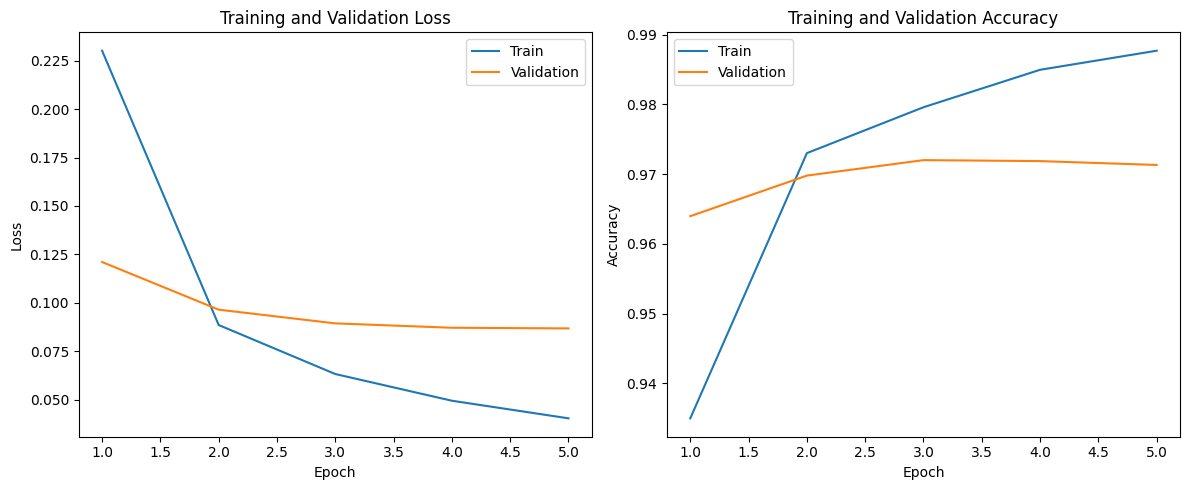

In [ ]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

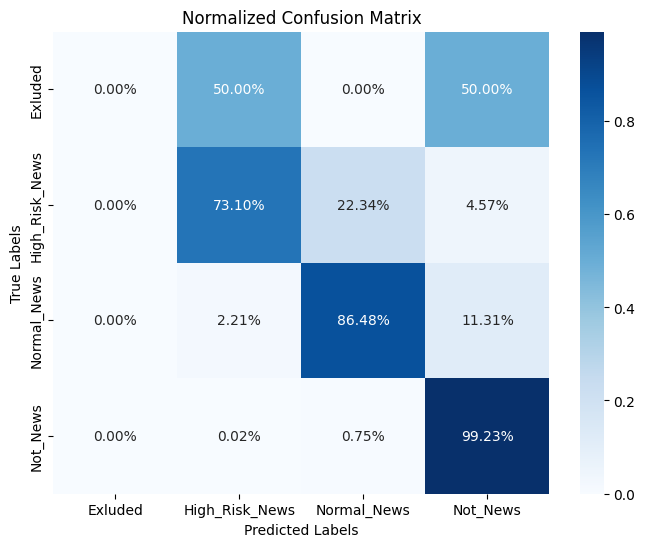


Classification Report:
                precision    recall  f1-score   support

       Exluded       0.00      0.00      0.00         2
High_Risk_News       0.88      0.73      0.80       197
   Normal_News       0.88      0.86      0.87       769
      Not_News       0.98      0.99      0.99      6248

      accuracy                           0.97      7216
     macro avg       0.69      0.65      0.67      7216
  weighted avg       0.97      0.97      0.97      7216



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot confusion matrix with percentages
def plot_confusion_matrix(cm, classes, normalize=False, cmap='Blues'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap=cmap,
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot normalized confusion matrix
plot_confusion_matrix(cm, label_encoder.classes_, normalize=True)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/tmp/ipykernel_33/2562058983.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')


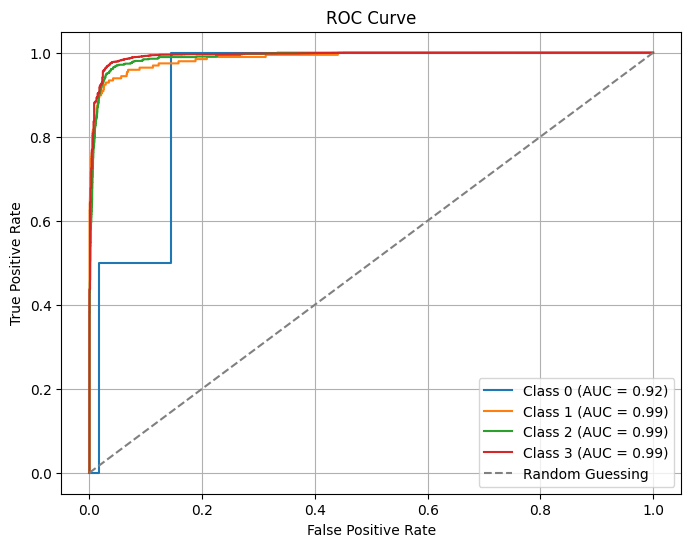

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for the ROC curve
n_classes = len(np.unique(y_test_true))
y_test_bin = label_binarize(y_test_true, classes=np.unique(y_test_true))

# Compute predicted probabilities
y_pred_proba = model.predict(X_test_vec.toarray())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


GB+ Deepgraphnet

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder


# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_vec.toarray(), y_train_encoded)

GradientBoostingClassifier()

In [ ]:


# Use the Gradient Boosting predictions as additional features
gb_train_predictions = gb_classifier.predict(X_train_vec.toarray())
gb_test_predictions = gb_classifier.predict(X_test_vec.toarray())

# Combine original features with Gradient Boosting predictions
X_train_combined = hstack((X_train_vec, gb_train_predictions.reshape(-1, 1)))
X_test_combined = hstack((X_test_vec, gb_test_predictions.reshape(-1, 1)))

# Now you can proceed with your Graph Neural Network (GNN) model using X_train_combined, X_val_combined, X_test_combined
# Example code for GNN training goes here...


In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt




# Define the model (ensure this uses the correct TensorFlow/Keras implementation)
class GCN(tf.keras.Model):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation=None)
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.dropout1 = tf.keras.layers.Dropout(0.5)

        self.dense2 = tf.keras.layers.Dense(32, activation=None)
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.dropout2 = tf.keras.layers.Dropout(0.5)

        self.dense3 = tf.keras.layers.Dense(16, activation=None)
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.ReLU()
        self.dropout3 = tf.keras.layers.Dropout(0.5)

        self.dense4 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.dense2(inputs)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.dense3(inputs)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.dense4(inputs)
        return x



In [ ]:
# Instantiate the model
num_node_features = X_train_vec.shape[1]
num_classes = len(label_encoder.classes_)
model = GCN(num_node_features=num_node_features, num_classes=num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
# Training loop with metrics calculation
num_epochs = 5
batch_size = 32

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    # Train the model
    history = model.fit(X_train_vec.toarray(), y_train_encoded, batch_size=batch_size, epochs=1, verbose=0)

    # Calculate training accuracy and loss
    train_loss = history.history['loss'][0]
    train_acc = history.history['accuracy'][0]


    # Validate the model
    val_loss, val_acc = model.evaluate(X_test_vec.toarray(), y_test_encoded, verbose=0)

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if epoch % 1 == 0:
        print(f'Epoch {epoch}/{num_epochs}')
        print(f'Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
        #print(f'Val - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')



Epoch 1/5
Train - Loss: 0.0341, Accuracy: 0.9898, Val - Loss: 0.0903, Accuracy: 0.9703
Epoch 2/5
Train - Loss: 0.0293, Accuracy: 0.9917, Val - Loss: 0.0911, Accuracy: 0.9712
Epoch 3/5
Train - Loss: 0.0257, Accuracy: 0.9930, Val - Loss: 0.0938, Accuracy: 0.9703
Epoch 4/5
Train - Loss: 0.0229, Accuracy: 0.9935, Val - Loss: 0.0976, Accuracy: 0.9695
Epoch 5/5
Train - Loss: 0.0208, Accuracy: 0.9941, Val - Loss: 0.1005, Accuracy: 0.9691


In [ ]:
# Predictions for validation set
y_test_pred = model.predict(X_test_vec.toarray()).argmax(axis=1)
y_test_true = y_test_encoded

# Calculate metrics for the validation set
val_accuracy = accuracy_score(y_test_true, y_test_pred)
val_precision = precision_score(y_test_true, y_test_pred, average='weighted')
val_recall = recall_score(y_test_true, y_test_pred, average='weighted')
val_f1 = f1_score(y_test_true, y_test_pred, average='weighted')

# Print metrics
print('Validation Metrics:')
print(f'Accuracy: {val_accuracy:.4f}')
print(f'Precision: {val_precision:.4f}')
print(f'Recall: {val_recall:.4f}')
print(f'F1-score: {val_f1:.4f}')


226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation Metrics:
Accuracy: 0.9691
Precision: 0.9680
Recall: 0.9691
F1-score: 0.9683


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


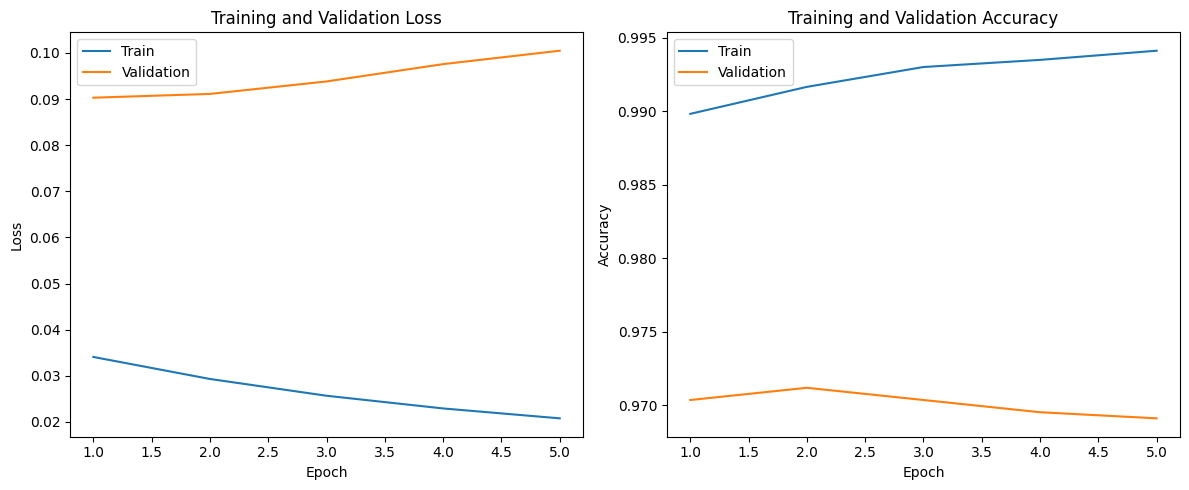

In [ ]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

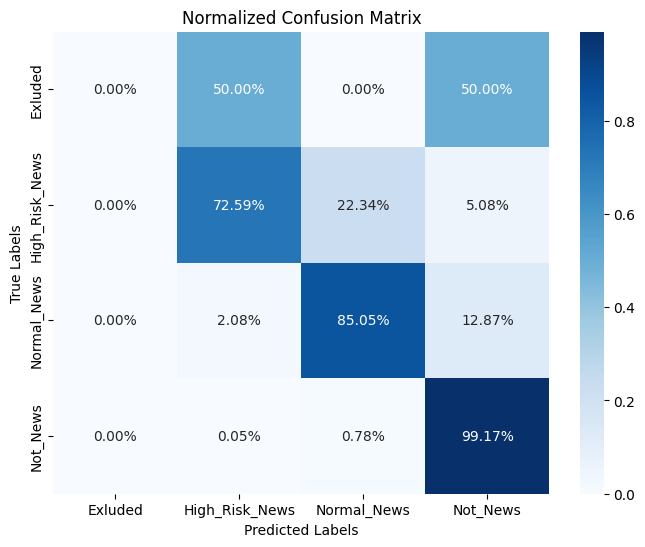


Classification Report:
                precision    recall  f1-score   support

       Exluded       0.00      0.00      0.00         2
High_Risk_News       0.88      0.73      0.79       197
   Normal_News       0.88      0.85      0.86       769
      Not_News       0.98      0.99      0.99      6248

      accuracy                           0.97      7216
     macro avg       0.68      0.64      0.66      7216
  weighted avg       0.97      0.97      0.97      7216



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot confusion matrix with percentages
def plot_confusion_matrix(cm, classes, normalize=False, cmap='Blues'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap=cmap,
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot normalized confusion matrix
plot_confusion_matrix(cm, label_encoder.classes_, normalize=True)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/tmp/ipykernel_33/2562058983.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')


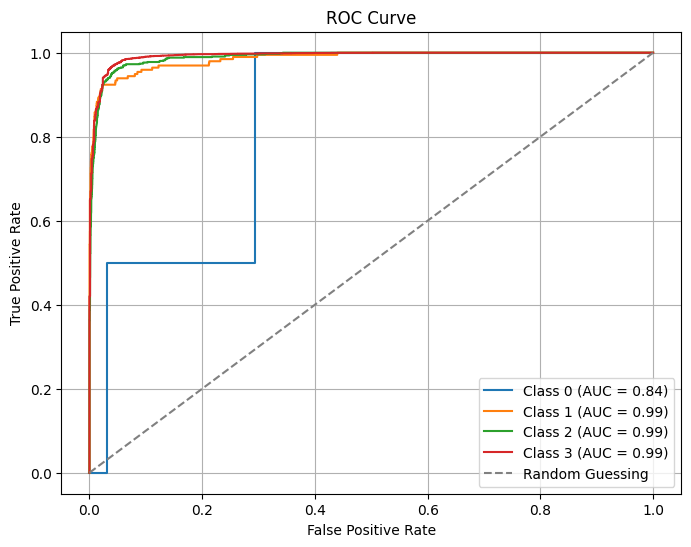

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for the ROC curve
n_classes = len(np.unique(y_test_true))
y_test_bin = label_binarize(y_test_true, classes=np.unique(y_test_true))

# Compute predicted probabilities
y_pred_proba = model.predict(X_test_vec.toarray())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


RF+Deepgraphnet

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_vec.toarray(), y_train_encoded)

# Use the Random Forest predictions as additional features
rf_train_predictions = rf_classifier.predict(X_train_vec.toarray())
rf_test_predictions = rf_classifier.predict(X_test_vec.toarray())

# Combine original features with Random Forest predictions
X_train_combined = hstack((X_train_vec, rf_train_predictions.reshape(-1, 1)))
X_test_combined = hstack((X_test_vec, rf_test_predictions.reshape(-1, 1)))

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt




# Define the model (ensure this uses the correct TensorFlow/Keras implementation)
class GCN(tf.keras.Model):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation=None)
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.dropout1 = tf.keras.layers.Dropout(0.5)

        self.dense2 = tf.keras.layers.Dense(32, activation=None)
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.dropout2 = tf.keras.layers.Dropout(0.5)

        self.dense3 = tf.keras.layers.Dense(16, activation=None)
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.ReLU()
        self.dropout3 = tf.keras.layers.Dropout(0.5)

        self.dense4 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.dense2(inputs)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.dense3(inputs)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.dense4(inputs)
        return x



In [ ]:
# Instantiate the model
num_node_features = X_train_vec.shape[1]
num_classes = len(label_encoder.classes_)
model = GCN(num_node_features=num_node_features, num_classes=num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
# Variables to store the best epoch and corresponding metrics
best_val_loss = float('inf')
best_epoch = 0
best_metrics = {}

# Training loop with validation and best epoch tracking
num_epochs = 5
batch_size = 32

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    # Train the model
    history = model.fit(X_train_vec.toarray(), y_train_encoded, batch_size=batch_size, epochs=1, verbose=0)

    # Calculate training accuracy and loss
    train_loss = history.history['loss'][0]
    train_acc = history.history['accuracy'][0]

    # Validate the model
    val_loss, val_acc = model.evaluate(X_test_vec.toarray(), y_test_encoded, verbose=0)

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        y_test_pred = np.argmax(model.predict(X_test_vec.toarray()), axis=1)

        # Calculate metrics for the validation set
        best_metrics = {
            "accuracy": accuracy_score(y_test_encoded, y_test_pred) * 100,
            "precision": precision_score(y_test_encoded, y_test_pred, average='weighted') * 100,
            "recall": recall_score(y_test_encoded, y_test_pred, average='weighted') * 100,
            "f1": f1_score(y_test_encoded, y_test_pred, average='weighted') * 100
        }

    if epoch % 1 == 0:
        print(f'Epoch {epoch}/{num_epochs}')
        print(f'Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

# Print the best epoch and corresponding metrics
print(f'\nBest Epoch: {best_epoch}')
print(f'Validation Accuracy: {best_metrics["accuracy"]:.2f}%')
print(f'Validation Precision: {best_metrics["precision"]:.2f}%')
print(f'Validation Recall: {best_metrics["recall"]:.2f}%')
print(f'Validation F1 Score: {best_metrics["f1"]:.2f}%')


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5
Train - Loss: 0.2312, Accuracy: 0.9343, Val - Loss: 0.1198, Accuracy: 0.9645


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2/5
Train - Loss: 0.0883, Accuracy: 0.9729, Val - Loss: 0.0959, Accuracy: 0.9690


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3/5
Train - Loss: 0.0631, Accuracy: 0.9803, Val - Loss: 0.0893, Accuracy: 0.9713


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4/5
Train - Loss: 0.0492, Accuracy: 0.9851, Val - Loss: 0.0866, Accuracy: 0.9716


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/5
Train - Loss: 0.0403, Accuracy: 0.9877, Val - Loss: 0.0873, Accuracy: 0.9710

Best Epoch: 4
Validation Accuracy: 97.16%
Validation Precision: 97.07%
Validation Recall: 97.16%
Validation F1 Score: 97.09%


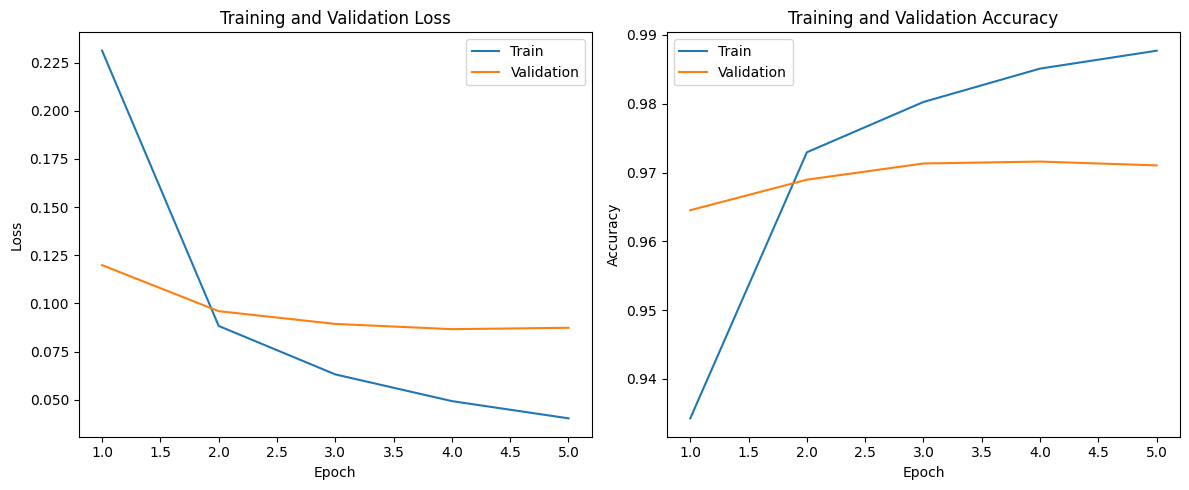

In [ ]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

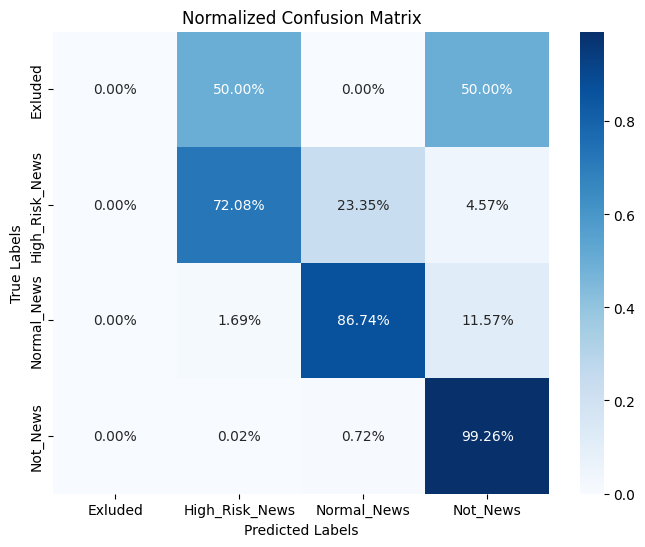


Classification Report:
                precision    recall  f1-score   support

       Exluded       0.00      0.00      0.00         2
High_Risk_News       0.90      0.72      0.80       197
   Normal_News       0.88      0.87      0.87       769
      Not_News       0.98      0.99      0.99      6248

      accuracy                           0.97      7216
     macro avg       0.69      0.65      0.67      7216
  weighted avg       0.97      0.97      0.97      7216



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot confusion matrix with percentages
def plot_confusion_matrix(cm, classes, normalize=False, cmap='Blues'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap=cmap,
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot normalized confusion matrix
plot_confusion_matrix(cm, label_encoder.classes_, normalize=True)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/tmp/ipykernel_33/2562058983.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')


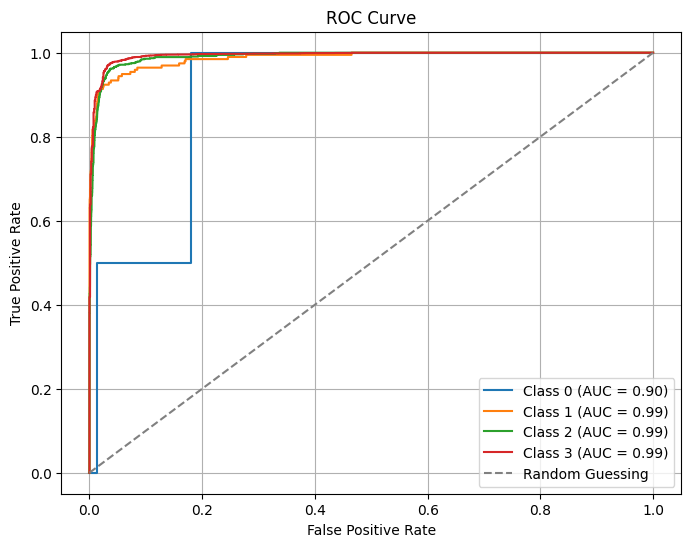

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for the ROC curve
n_classes = len(np.unique(y_test_true))
y_test_bin = label_binarize(y_test_true, classes=np.unique(y_test_true))

# Compute predicted probabilities
y_pred_proba = model.predict(X_test_vec.toarray())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
